In [8]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)


In [27]:
'''
with open('test.txt', 'r') as f:
    tickers = f.read().splitlines()

df = pd.DataFrame(yf.download('MSFT', start='2015-01-01'))
for ticker in tickers:
    row = yf.download(ticker, start='2015-01-01')
    df = pd.concat([df, row], ignore_index=True)

df'''

"\nwith open('test.txt', 'r') as f:\n    tickers = f.read().splitlines()\n\ndf = pd.DataFrame(yf.download('MSFT', start='2015-01-01'))\nfor ticker in tickers:\n    row = yf.download(ticker, start='2015-01-01')\n    df = pd.concat([df, row], ignore_index=True)\n\ndf"

In [28]:
def backtest(ticker, start_date, stop_loss_percent, exit_price_percent, plot:bool):
    # fetch data with yfinance, clean
    data = yf.download(ticker, start=start_date, progress=False)
    data = data[['Close']].copy()
    data.dropna(inplace=True)

    # handle empty data
    if data.empty:
        return [0, 0, 0]
    
    # initialize experiment
    entry_price = data.iloc[0]['Close'].item()
    stop_loss = entry_price - entry_price * (stop_loss_percent / 100)
    exit_price = entry_price + entry_price * (exit_price_percent / 100)
    #data['Daily Return'] = data['Close'].pct_change()
    #data['Cumulative Return'] = (1 + data['Daily Return']).cumprod()

    # run trade exit simulation
    exit_index = None
    for idx, price in enumerate(data['Close'].iloc[:,0]):
        if price <= stop_loss:
            exit_index = idx
            break
        if price >= exit_price:
            exit_index = idx
            break

    # trim data to exit index (price behavior after this is unecessary)
    if exit_index is not None:
        data = data.iloc[:exit_index + 1]

    # download historical data for the S&P 500 index for comparison
    start_date = data.index[0]
    end_date = data.index[-1] + pd.Timedelta(days=1)
    sp500_data = yf.download("^GSPC", start=start_date, end=end_date)
    sp500_data = sp500_data[['Close']].dropna()
    # handle empty or insufficient S&P 500 data
    if sp500_data.empty or len(sp500_data) < 2:
        sp500_return = 0
    else:
        try:
            sp500_start = sp500_data.loc[sp500_data.index >= start_date, 'Close'].iloc[0].item()
            sp500_end = sp500_data.loc[sp500_data.index <= data.index[-1], 'Close'].iloc[-1].item()
            sp500_return = (sp500_end - sp500_start) / sp500_start
        except IndexError:
            return [0, 0, 0]  # fallback in case of any unexpected missing data

    # calculate total performance of strategy and simultanious performance of the smp500
    try:
        final_price = data.iloc[-1]['Close'].item()
        total_return = (final_price - entry_price) / entry_price
    except:
        return [0, 0, 0] # fallback in case of divide by zero

    if (plot):
        # generate plot
        plt.figure(figsize=(10, 5))
        plt.plot(data.index, data['Close'].iloc[:,0].values, label='Daily Price')
        plt.margins(x=0.05, y=0.1)
        plt.axhline(y=exit_price, color='green', linestyle='--', label='Exit Price')
        plt.axhline(y=stop_loss, color='red', linestyle='--', label='Stop Loss')
        plt.title(f"{ticker} Trade Simulation beginning {start_date}")
        plt.xlabel("Date")
        plt.ylabel("Valuation (USD)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # print report
        print(f"Entry Price: ${entry_price:.2f}")
        print(f"Final Price:  ${final_price:.2f}")
        print(f"Holding Period: {len(data)} days")
        print(f"Total Return: {total_return:.2%}")
        #print(f"Equivalent SMP 500: {sp500_return:.2%}")
    else:
       return [total_return, sp500_return, len(data)]

In [29]:
# visualize a ticker using a given stop loss and exit price strategy
backtest(ticker="AAPL", start_date="2023-01-01", stop_loss_percent=20, exit_price_percent=60, plot=False)

[*********************100%***********************]  1 of 1 completed


[0.6699172325759857, 0.40562844854372315, 362]

[*********************100%***********************]  1 of 1 completed


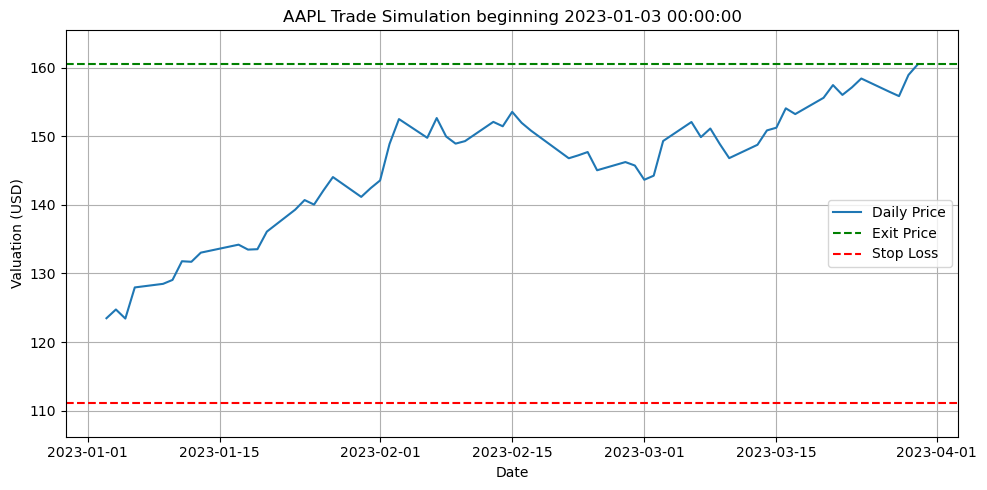

Entry Price: $123.47
Final Price:  $160.53
Holding Period: 61 days
Total Return: 30.01%


In [30]:
# return a list containing a single ticker vs SMP500 performance using a given stop loss and exit price strategy (and how long the hold would have been)
backtest(ticker="AAPL", start_date="2023-01-01", stop_loss_percent=10, exit_price_percent=30, plot=True)

In [31]:
# compare a series of tickers using a given stop loss and exit price strategy
with open('clean_tickers.txt', 'r') as f:
    tickers = f.readlines()

tickers = [line.strip() for line in tickers]

df = pd.DataFrame({'Ticker':[],
                  'SMP500':[],
                  'Days Held':[]})

for ticker in tickers:
    result = backtest(ticker=ticker, start_date="2015-01-01", stop_loss_percent=10, exit_price_percent=30, plot=False)
    new_row = pd.DataFrame({'Ticker':[result[0]], 'SMP500':[result[1]], 'Days Held':[result[2]]})
    df = pd.concat([df, new_row], ignore_index=True)

df.to_csv('results.csv', index=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [32]:
loaded_df = pd.read_csv('results.csv')
loaded_df

Ticker    SMP500  Days Held
0     -0.102778 -0.055928      256.0
1     -0.103911 -0.022801        9.0
2      0.442694  0.028904       78.0
3      0.302096  0.002872      343.0
4      0.341299  0.008235      205.0
...         ...       ...        ...
52651 -0.121447  0.005747        2.0
52652 -0.128885  0.049748       84.0
52653 -0.204545  0.064067       98.0
52654  0.313845  0.009902      219.0
52655  0.308214  0.019920      218.0

[52656 rows x 3 columns]

In [46]:
df2 = loaded_df.copy()
df2 = df2[(df2['Ticker'] != 0) | (df2['SMP500'] != 0) | (df2['Days Held'] != 0)]
df2 = df2[df2['Ticker'] < 0.5]
df2

Ticker    SMP500  Days Held
0     -0.102778 -0.055928      256.0
1     -0.103911 -0.022801        9.0
2      0.442694  0.028904       78.0
3      0.302096  0.002872      343.0
4      0.341299  0.008235      205.0
...         ...       ...        ...
52651 -0.121447  0.005747        2.0
52652 -0.128885  0.049748       84.0
52653 -0.204545  0.064067       98.0
52654  0.313845  0.009902      219.0
52655  0.308214  0.019920      218.0

[50339 rows x 3 columns]

In [47]:
print(np.mean(df2['Ticker']), np.mean(df2['SMP500']), np.mean(df2['Ticker']) - np.mean(df2['SMP500']))

-0.0011745124065764565 0.028242149692424195 -0.02941666209900065


In [48]:
np.mean(df2['Days Held'])

136.04819324976657